In [1]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import json
import talib as talib
from talib import MA_Type, OBV, ATR, WCLPRICE, AVGPRICE, STDDEV
from matplotlib import pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

In [2]:
#df = pd.read_csv (r'../CSV/oneStockAAPL.csv', sep=',')
df = pd.read_csv (r'../CSV/all_stocks.csv', sep=',')
list_of_stocks = df['Symbol'].unique()
print(list_of_stocks.size)

# Casting Timestamp to type datetime64[ns]
df['Timestamp'] = df['Timestamp'].astype('datetime64[ns]')

df.drop('Dividends', axis=1, inplace=True)
df.drop('Stock Splits', axis=1, inplace=True)

print(df)

100
             Open       High        Low      Close     Volume Symbol  \
0       24.648955  24.976733  24.526886  24.820757  195826400   AAPL   
1       24.865962  24.879525  24.110942  24.147110  240056000   AAPL   
2       24.194581  24.318911  23.780901  23.959484  314053200   AAPL   
3       24.377689  24.633132  24.074777  24.576618  199599600   AAPL   
4       24.628612  25.105587  24.474895  24.764246  194303600   AAPL   
...           ...        ...        ...        ...        ...    ...   
176889  48.740002  49.880001  47.580002  49.459999   38629700     GM   
176890  50.310001  51.680000  50.160000  50.720001   24290800     GM   
176891  49.730000  51.790001  49.599998  50.340000   17017600     GM   
176892  50.639999  50.970001  48.540001  48.830002   20173900     GM   
176893  48.869999  49.189999  48.000000  48.400002   17534300     GM   

        Timestamp  
0      2015-01-14  
1      2015-01-15  
2      2015-01-16  
3      2015-01-20  
4      2015-01-21  
...        

In [3]:
# Functions
def checkNonesString(df):
    # CHECK Object column for "None" strings.
    print(df[df['Symbol'].str.contains('None')].any())
    

def checkNans(df):
    # Check if there are NaNs
    print("-----IS NA per COL-------")
    print("Doesn't seem to be working")
    print(df[df.isna().any(axis=1)].sum())

    print("-----IS NA per COL-------")
    print(df.isna().sum())

    print("------printing sum of Nans for each column------")
    for col in df.columns:
        print(col + ": " + str(df[col].isnull().sum()))
        
        
def checkInfs(df):
    print("-------total amount of Infs per Column-----------")
    print(df.groupby(np.isinf(df["Open"])).count())

    print("-------total amount of Infs-----------")
    count = np.isinf(df["Open"]).values.sum()
    print("It contains " + str(count) + " infinite values")


def printDataframe(df):
    # Prints
    print("-----DATAFRAME HEAD-------")
    print(df.head(10))

    print("-----DATAFRAME TAIL-------")
    print(df.tail(10))
    
    print("-----SHAPE-------")
    print(df.shape)

    print("-----COLUMNS-------")
    print(df.columns)

    print("-----DATATYPES-------")
    print(df.dtypes)



In [4]:
# Adding week number, to be able to derived the Weekly labels.
#df.insert(1, 'Week_Number', df['Timestamp'].dt.week)

# Creating temp dataframe yp use in loop
df_merged = pd.DataFrame()

# Creating labels
#for ticker in list_of_stocks:
    #temp = df[df["Symbol"] == ticker]
    #temp["Close1d%"] = temp["Close"].pct_change(periods=-1).shift(periods=0)
    #temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
    #temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
    #temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
    #temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
    #df_merged = pd.concat([df_merged, temp], axis=0)

#df = df_merged
printDataframe(df)
checkNans(df)

-----DATAFRAME HEAD-------
        Open       High        Low      Close     Volume Symbol  Timestamp
0  24.648955  24.976733  24.526886  24.820757  195826400   AAPL 2015-01-14
1  24.865962  24.879525  24.110942  24.147110  240056000   AAPL 2015-01-15
2  24.194581  24.318911  23.780901  23.959484  314053200   AAPL 2015-01-16
3  24.377689  24.633132  24.074777  24.576618  199599600   AAPL 2015-01-20
4  24.628612  25.105587  24.474895  24.764246  194303600   AAPL 2015-01-21
5  24.924739  25.424319  24.802670  25.408495  215185600   AAPL 2015-01-22
6  25.385891  25.713669  25.211828  25.539608  185859200   AAPL 2015-01-23
7  25.711407  25.851561  25.498917  25.566732  222460000   AAPL 2015-01-26
8  25.413016  25.426580  24.646692  24.671558  382274800   AAPL 2015-01-27
9  26.590757  26.701524  26.066311  26.066311  585908400   AAPL 2015-01-28
-----DATAFRAME TAIL-------
             Open       High        Low      Close    Volume Symbol  Timestamp
176884  52.849998  54.240002  52.119999  5

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/1697045615.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df[df.isna().any(axis=1)].sum())


In [5]:
# Adding Numerical indicators/features in a for loop, for all stocks.
list_to_category = []
list_to_percentage = []

# For loop creating new features and labels per stock.
for ticker in list_of_stocks:
    
    # creating a subdataframe based on ticker(Stock)
    temp = df[df["Symbol"] == ticker]

    # Creating Labels
    temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
    temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
    temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
    temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
    temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
    
    
    #-------- Price comparable indicators------------
    
    # BB
    temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
    list_to_category.extend(["BB upper", "BB lower"])
    list_to_percentage.extend(["BB upper", "BB lower"])    

    # SMA 0-50
    for i in range(5,25,5):
        tempColName = "SMA" + str(i)
        list_to_category.append(tempColName)
        list_to_percentage.append(tempColName)
        temp[tempColName] = talib.SMA(temp["Close"], i)

    # SMA 50-300
    for i in range(50,300,50):
        tempColName = "SMA" + str(i)
        list_to_category.append(tempColName)
        list_to_percentage.append(tempColName)
        temp[tempColName] = talib.SMA(temp["Close"], i)
        
    # Weighted Closed Price
    temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
    list_to_category.append("WCLPRICE")
    list_to_percentage.append("WCLPRICE")

    # AVG Price
    temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
    list_to_category.append("AVGPRICE")
    list_to_percentage.append("AVGPRICE")
    
    # STD deviation
    temp["STD-5/1"] = STDDEV(temp["Close"], timeperiod=5, nbdev=1)
    temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
    temp["STD-10/1"] = STDDEV(temp["Close"], timeperiod=10, nbdev=1)
    temp["STD-10/2"] = STDDEV(temp["Close"], timeperiod=10, nbdev=2)
    list_to_category.extend(["STD-5/1", "STD-5/2", "STD-10/1", "STD-10/2"])
    list_to_percentage.extend(["STD-5/1", "STD-5/2", "STD-10/1", "STD-10/2"])

    #-------- Other indicators------------
    
    # OBV
    temp["OBV"] = OBV(temp["Close"], temp["Volume"])
    
    # ATR
    temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
    temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)

    # RSI
    temp["RSI"] = talib.RSI(temp["Close"])
    
    # Momentum
    temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)

    # MACD
    temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])

    # Merging
    df_merged = pd.concat([df_merged, temp], axis=0)

# Renaming and printing
df = df_merged
printDataframe(df)
checkNans(df)

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-10/2"] = STDDEV(temp["Close"], timeperiod=10, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OBV"] = OBV(temp["Close"], temp["Volume"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/1"] = STDDEV(temp["Close"], timeperiod=5, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/1"] = STDDEV(temp["Close"], timeperiod=5, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OBV"] = OBV(temp["Close"], temp["Volume"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyW

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-10/1"] = STDDEV(temp["Close"], timeperiod=10, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OBV"] = OBV(temp["Close"], temp["Volume"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-10/2"] = STDDEV(temp["Close"], timeperiod=10, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OBV"] = OBV(temp["Close"], temp["Volume"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/1"] = STDDEV(temp["Close"], timeperiod=5, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyW

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/1"] = STDDEV(temp["Close"], timeperiod=5, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a cop

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-10/1"] = STDDEV(temp["Close"], timeperiod=10, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyW

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OBV"] = OBV(temp["Close"], temp["Volume"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyW

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a cop

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/2"] = STDDEV(temp["Close"], timeperiod=5, nbdev=2)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-10/1"] = STDDEV(temp["Close"], timeperiod=10, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close15d%"] = temp["Close"].pct_change(periods=-15).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["STD-5/1"] = STDDEV(temp["Close"], timeperiod=5, nbdev=1)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close10d%"] = temp["Close"].pct_change(periods=-10).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["RSI"] = talib.RSI(temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["WCLPRICE"] = WCLPRICE(temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["AVGPRICE"] = AVGPRICE(temp["Open"], temp["High"], temp["Low"], temp["Close"])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:31: SettingWithCopyW

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close1d%"] = (temp["Close"].pct_change(periods=-1).shift(periods=0)) * -1
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close5d%"] = temp["Close"].pct_change(periods=-5).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR14"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=14)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ATR5"] = ATR(temp["High"], temp["Low"], temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[tempColName] = talib.SMA(temp["Close"], i)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Close20d%"] = temp["Close"].pct_change(periods=-20).shift(periods=0)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["BB upper"], temp["BB middle"], temp["BB lower"] = talib.BBANDS(temp["Close"], matype=MA_Type.T3)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:22: SettingWithCopyWarning: 
A value is trying t

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Momentum"] = talib.MOM(temp["Close"], timeperiod=5)
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["macd"], temp["macd_signal"], temp["macd_hist"] = talib.MACD(temp['Close'])
C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/2129588112.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-----DATAFRAME HEAD-------
        Open       High        Low      Close     Volume Symbol  Timestamp  \
0  24.648955  24.976733  24.526886  24.820757  195826400   AAPL 2015-01-14   
1  24.865962  24.879525  24.110942  24.147110  240056000   AAPL 2015-01-15   
2  24.194581  24.318911  23.780901  23.959484  314053200   AAPL 2015-01-16   
3  24.377689  24.633132  24.074777  24.576618  199599600   AAPL 2015-01-20   
4  24.628612  25.105587  24.474895  24.764246  194303600   AAPL 2015-01-21   
5  24.924739  25.424319  24.802670  25.408495  215185600   AAPL 2015-01-22   
6  25.385891  25.713669  25.211828  25.539608  185859200   AAPL 2015-01-23   
7  25.711407  25.851561  25.498917  25.566732  222460000   AAPL 2015-01-26   
8  25.413016  25.426580  24.646692  24.671558  382274800   AAPL 2015-01-27   
9  26.590757  26.701524  26.066311  26.066311  585908400   AAPL 2015-01-28   

   Close1d%  Close5d%  Close10d%  ...  STD-10/1  STD-10/2          OBV  ATR14  \
0 -0.027898 -0.023132  -0.076535 

SMA250: 24900
WCLPRICE: 0
AVGPRICE: 0
STD-5/1: 400
STD-5/2: 400
STD-10/1: 900
STD-10/2: 900
OBV: 0
ATR14: 1400
ATR5: 500
RSI: 1400
Momentum: 500
macd: 3300
macd_signal: 3300
macd_hist: 3300


In [6]:
# A checking of values validity
checkNonesString(df)
checkNans(df)
checkInfs(df)
printDataframe(df)

Open           False
High           False
Low            False
Close          False
Volume         False
Symbol         False
Timestamp      False
Close1d%       False
Close5d%       False
Close10d%      False
Close15d%      False
Close20d%      False
BB upper       False
BB middle      False
BB lower       False
SMA5           False
SMA10          False
SMA15          False
SMA20          False
SMA50          False
SMA100         False
SMA150         False
SMA200         False
SMA250         False
WCLPRICE       False
AVGPRICE       False
STD-5/1        False
STD-5/2        False
STD-10/1       False
STD-10/2       False
OBV            False
ATR14          False
ATR5           False
RSI            False
Momentum       False
macd           False
macd_signal    False
macd_hist      False
dtype: bool
-----IS NA per COL-------
Doesn't seem to be working
Open                                             64584786.908318
High                                             64951620.607418
Low    

C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/1697045615.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df[df.isna().any(axis=1)].sum())


C:\Users\Eric\AppData\Local\Temp/ipykernel_1912/1697045615.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df[df.isna().any(axis=1)].sum())


-----IS NA per COL-------
Doesn't seem to be working
Open                                             10067169.534541
High                                             10166438.714779
Low                                               9934030.723866
Close                                            10053777.288448
Volume                                               30848561515
Symbol         AAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAA...
Close1d%                                               -4.700333
Close5d%                                                2.725273
Close10d%                                              -9.235349
Close15d%                                               2.087253
Close20d%                                              -0.825287
BB upper                                         10281424.504967
BB middle                                        10075056.954212
BB lower                                          9868689.403457
SMA5                                 

No handles with labels found to put in legend.


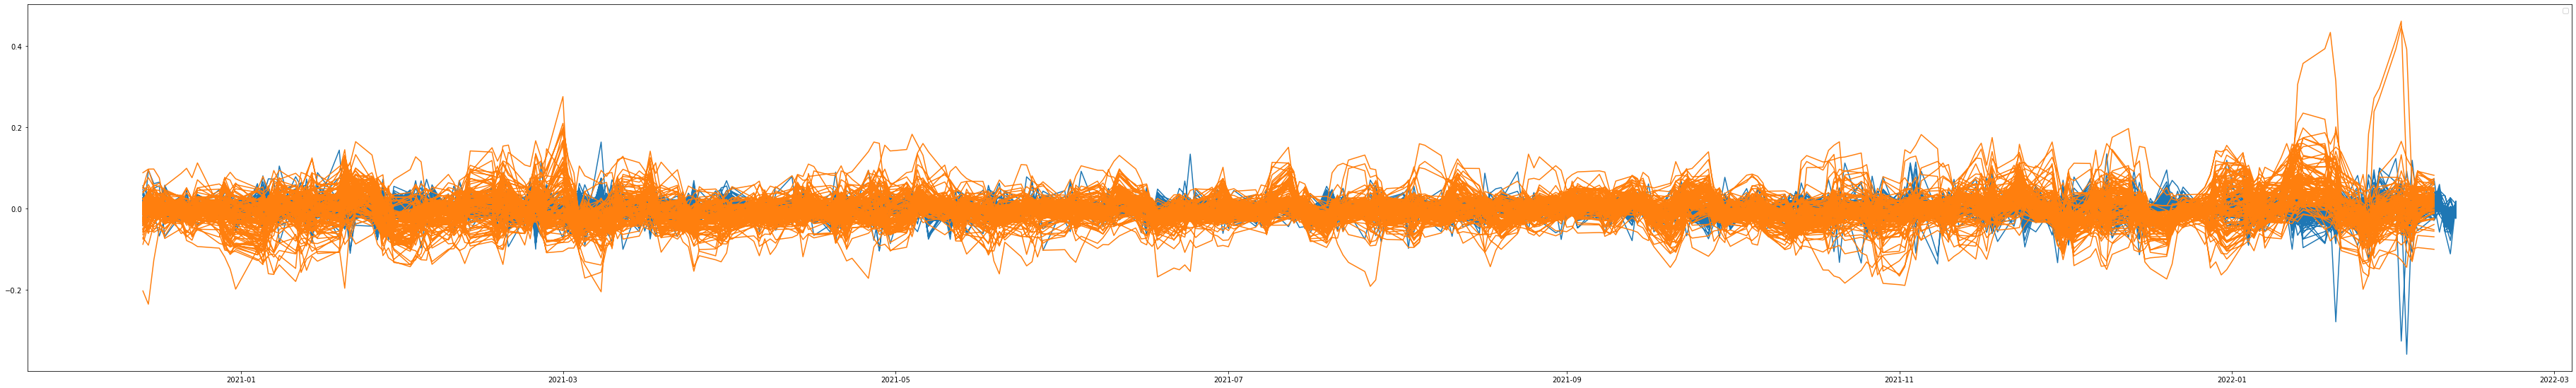

In [7]:
# Example plotting
df_plot = df[df["Timestamp"] > '2020-12-12']
df_plot.index = df_plot["Timestamp"]

checkNans(df_plot)

fig = plt.figure()
fig.set_size_inches((50, 36))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))

# Plotting the RSI boundaries
#ax_rsi.plot(df_plot.index, [70] * len(df_plot.index), label="overbought")
#ax_rsi.plot(df_plot.index, [30] * len(df_plot.index), label="oversold")
#ax_rsi.plot(df_plot.index, df_plot["RSI"], label="rsi")

# Plotting the BB 
#ax_rsi.plot(df_plot.index,df_plot["BB upper"],  label="BBhigh", color ="purple")
#ax_rsi.plot(df_plot.index,df_plot["BB lower"], label="BBlow", color ="purple")
#ax_rsi.plot(df_plot.index,df_plot["BB middle"], label="BBmiddle", color ="purple")

# Plotting Volume
#ax_rsi.plot(df_plot.index,(df_plot["OBV"] / 1000000000), label="OBV", color ="teal")


# Plotting OBV
#ax_rsi.plot(df_plot.index, (df_plot["OBV"] / 1000000000), label="OBV", color ="teal")
ax_rsi.plot(df_plot.index, df_plot["Close1d%"])
ax_rsi.plot(df_plot.index, df_plot["Close5d%"])

# plotting the Price
#ax_rsi.plot(df_plot.index, (df_plot["Volume"] / 10000000), label = "Vol", color= "black")  # density=False would make counts
#ax_rsi.plot(df_plot["Close"], label = "Price")
#ax_rsi.plot((df_plot["Volume"] / 10000000), label="Vol", color ="Black")
ax_rsi.legend()

In [8]:
# Categoriacl feature engineering represented as binary
print(list_to_category)
#print(list_to_category)
for col in list_to_category:
    under = "Under " + col 
    over = "Over " + col 
    df[under] = df[col] <= df["Close"]
    df[over] = df[col] > df["Close"]
    df[under] = df[under].astype(int)
    df[over] = df[over].astype(int)
    
print(df.columns)
print(df.head(30))


['BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', '

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Symbol', 'Timestamp',
       'Close1d%', 'Close5d%', 'Close10d%', 'Close15d%', 'Close20d%',
       'BB upper', 'BB middle', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20',
       'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE',
       'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'OBV', 'ATR14', 'ATR5',
       'RSI', 'Momentum', 'macd', 'macd_signal', 'macd_hist', 'Under BB upper',
       'Over BB upper', 'Under BB lower', 'Over BB lower', 'Under SMA5',
       'Over SMA5', 'Under SMA10', 'Over SMA10', 'Under SMA15', 'Over SMA15',
       'Under SMA20', 'Over SMA20', 'Under SMA50', 'Over SMA50',
       'Under SMA100', 'Over SMA100', 'Under SMA150', 'Over SMA150',
       'Under SMA200', 'Over SMA200', 'Under SMA250', 'Over SMA250',
       'Under WCLPRICE', 'Over WCLPRICE', 'Under AVGPRICE', 'Over AVGPRICE',
       'Under STD-5/1', 'Over STD-5/1', 'Under STD-5/2', 'Over STD-5/2',
       'Under STD-10/1', 'Over STD-10/

In [9]:
# % difference from price Features
print(list_to_percentage)
for col in list_to_percentage:
    col_name = "% " + col 
    df[col_name] = df[col] / df["Close"]
    #df[col_name] = df["Close"] / df[col]

['BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', '

In [10]:
# correlation calculation
feature_corr = df.copy().corr()

# Sorting
sortedDesc1d = feature_corr["Close1d%"].sort_values(ascending=False) 
sortedDesc5d = feature_corr["Close5d%"].sort_values(ascending=False) 
sortedDesc10d = feature_corr["Close10d%"].sort_values(ascending=False) 
sortedDesc15d = feature_corr["Close15d%"].sort_values(ascending=False) 
sortedDesc20d = feature_corr["Close20d%"].sort_values(ascending=False) 

# Printing
print(sortedDesc1d.head(10))
print(sortedDesc5d.head(10))
print(sortedDesc10d.head(10))
print(sortedDesc15d.head(10))
print(sortedDesc20d.head(10))

Close1d%         1.000000
% WCLPRICE       0.088912
% AVGPRICE       0.075448
% SMA5           0.038687
% SMA10          0.032374
% BB lower       0.029850
Over WCLPRICE    0.028498
Over AVGPRICE    0.028080
% SMA15          0.026581
% BB upper       0.026121
Name: Close1d%, dtype: float64
Close5d%          1.000000
Close10d%         0.689215
Close15d%         0.559348
Close20d%         0.478630
Under STD-5/2     0.022926
Under STD-5/1     0.022926
Under WCLPRICE    0.022924
Under SMA100      0.022775
RSI               0.020815
Under AVGPRICE    0.020468
Name: Close5d%, dtype: float64
Close10d%         1.000000
Close15d%         0.796966
Close5d%          0.689215
Close20d%         0.684585
Under SMA100      0.030087
Under WCLPRICE    0.022577
Under SMA150      0.020757
Under AVGPRICE    0.020497
Under SMA50       0.019908
RSI               0.019566
Name: Close10d%, dtype: float64
Close15d%       1.000000
Close20d%       0.847809
Close10d%       0.796966
Close5d%        0.559348
Under 

In [11]:
# Exporting as CSV 
#df.to_csv(r'../CSV/FeaturesAAPL.csv', sep= ",", index = False)